# 이미지 준비하기

In [1]:
import os

img_path = os.getenv('HOME') + '/aiffel/ocr_python/file'
img = os.listdir(img_path)
print(img)

['01.jpeg', '06.jpeg', '03.jpeg', '02.jpeg', '04.jpeg', '05.jpeg']


In [2]:
# 현재 디렉토리 변경
os.chdir('./file')
print(os.getcwd())

/aiffel/aiffel/ocr_python/file


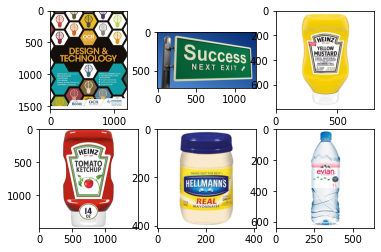

In [3]:
# 이미지 시각화(6장)
import matplotlib.pyplot as plt

for i in range(len(img)):
    plt.subplot(2,3,i+1)
    plt.imshow(plt.imread(img[i]))

#  Google Cloud Vision API 사용

In [4]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [5]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
for i in range(1,7):
    a = '/aiffel/ocr_python/file/'+'0'+str(i)+'.jpeg'
    path = os.getenv('HOME')+a
    print('-'*50,str(i),'jpeg','-'*50)
    detect_text(path)

total 552
-rw-r--r-- 1 root root 196567 Feb 24 06:47 01.jpeg
-rw-r--r-- 1 root root 132234 Feb 24 06:47 02.jpeg
-rw-r--r-- 1 root root  33186 Feb 24 06:47 03.jpeg
-rw-r--r-- 1 root root  20854 Feb 24 06:47 04.jpeg
-rw-r--r-- 1 root root  21725 Feb 24 06:47 05.jpeg
-rw-r--r-- 1 root root 146951 Feb 24 06:47 06.jpeg
-------------------------------------------------- 1 jpeg --------------------------------------------------
Texts:

"OCR
AS/A LEVEL
DESIGN &
TECHNOLOGY
John Grundy (SERIES EDITOR)
Sharon McCarthy
COVERS ALL ENDORSED TITLES
OF THE OCR AS AND A LEVEL
Jacki Piroddi
SPECIFICATIONS:
Chris Walker
• Design Engineering
Simeon Arnold (CONTRIBUTOR)
Fashion and Textiles
John White (CONTRIBUTOR)
Product Design
An OCR endorsed textbook
OCR
G HODDER
EDUCATION
Boost
Oxford Cambridge and RSA
LEARN MORE
"

"OCR"

"AS/A"

"LEVEL"

"DESIGN"

"&"

"TECHNOLOGY"

"John"

"Grundy"

"(SERIES"

"EDITOR)"

"Sharon"

"McCarthy"

"COVERS"

"ALL"

"ENDORSED"

"TITLES"

"OF"

"THE"

"OCR"

"AS"

"AND"

"

# keras-ocr

In [6]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [7]:
img_array = [plt.imread(i) for i in img]

In [8]:
for i in range(len(img_array)):
    print('{} 인덱스 그림의 크기는: '.format(i), img_array[i].shape)

0 인덱스 그림의 크기는:  (1555, 1200, 3)
1 인덱스 그림의 크기는:  (719, 1278, 3)
2 인덱스 그림의 크기는:  (800, 800, 3)
3 인덱스 그림의 크기는:  (1500, 1500, 3)
4 인덱스 그림의 크기는:  (410, 410, 3)
5 인덱스 그림의 크기는:  (640, 640, 3)


In [9]:
import cv2 
cv2_img_array = [cv2.imread(i) for i in img]

prediction_groups = [pipeline.recognize([url]) for url in cv2_img_array]

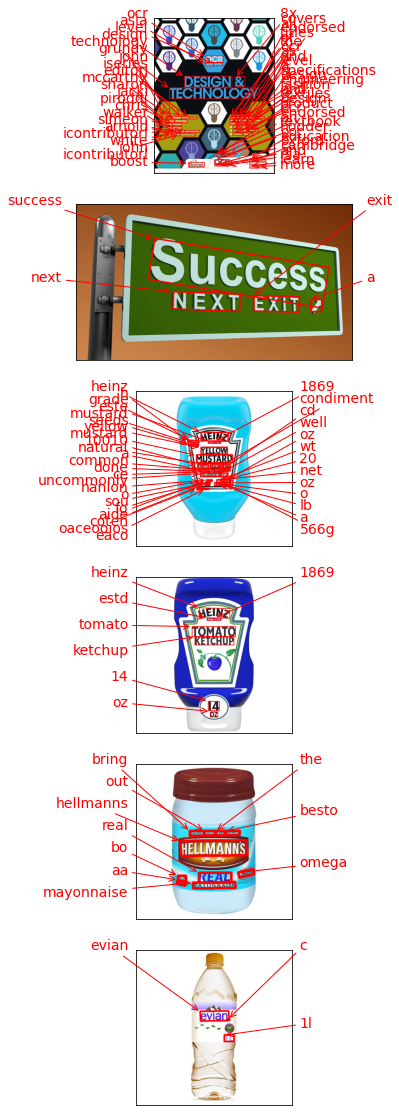

In [10]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(cv2_img_array), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=cv2_img_array[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

# 테서랙트

In [12]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt


def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [13]:
cropped_image_path_list = []
for i in range(len(img)):
    cropped_image_path_list.append(crop_word_regions(os.getcwd() + '/' + img[i],os.getcwd()))

for cropped_image in cropped_image_path_list:
    print(cropped_image)
    print('------------------------------------------------------')

/aiffel/aiffel/ocr_python/file/0000.png
/aiffel/aiffel/ocr_python/file/0000.png
/aiffel/aiffel/ocr_python/file/0000.png
/aiffel/aiffel/ocr_python/file/0000.png
/aiffel/aiffel/ocr_python/file/0000.png
/aiffel/aiffel/ocr_python/file/0001.png
/aiffel/aiffel/ocr_python/file/0002.png
/aiffel/aiffel/ocr_python/file/0003.png
/aiffel/aiffel/ocr_python/file/0004.png
/aiffel/aiffel/ocr_python/file/0005.png
/aiffel/aiffel/ocr_python/file/0000.png
['/aiffel/aiffel/ocr_python/file/0000.png']
------------------------------------------------------
['/aiffel/aiffel/ocr_python/file/0000.png']
------------------------------------------------------
['/aiffel/aiffel/ocr_python/file/0000.png']
------------------------------------------------------
['/aiffel/aiffel/ocr_python/file/0000.png']
------------------------------------------------------
['/aiffel/aiffel/ocr_python/file/0000.png', '/aiffel/aiffel/ocr_python/file/0001.png', '/aiffel/aiffel/ocr_python/file/0002.png', '/aiffel/aiffel/ocr_python/file/00

In [14]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.

for i in range(len(cropped_image_path_list)):
    print('이미지 이름: ',img[i])
    print(recognize_images(cropped_image_path_list[i]))
    print('------------------------------------------------------')

이미지 이름:  01.jpeg
.

Done
None
------------------------------------------------------
이미지 이름:  06.jpeg
.

Done
None
------------------------------------------------------
이미지 이름:  03.jpeg
.

Done
None
------------------------------------------------------
이미지 이름:  02.jpeg
.

Done
None
------------------------------------------------------
이미지 이름:  04.jpeg
.

san

REAL

MAYONNAISE

ge


Done
None
------------------------------------------------------
이미지 이름:  05.jpeg
.

Done
None
------------------------------------------------------


# 시각화

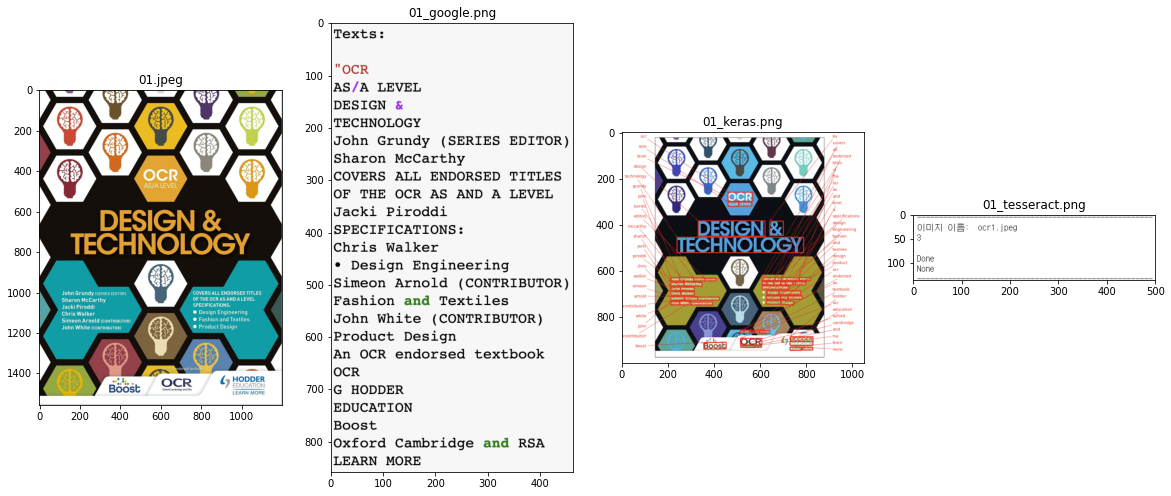

In [16]:
test_img1 = ['01.jpeg', '01_google.png', '01_keras.png', '01_tesseract.png']

plt.figure(figsize=(20,15))
for i in range(len(test_img1)):
    plt.subplot(1,4, i+1)
    plt.title(test_img1[i])
    plt.imshow(plt.imread(test_img1[i]))

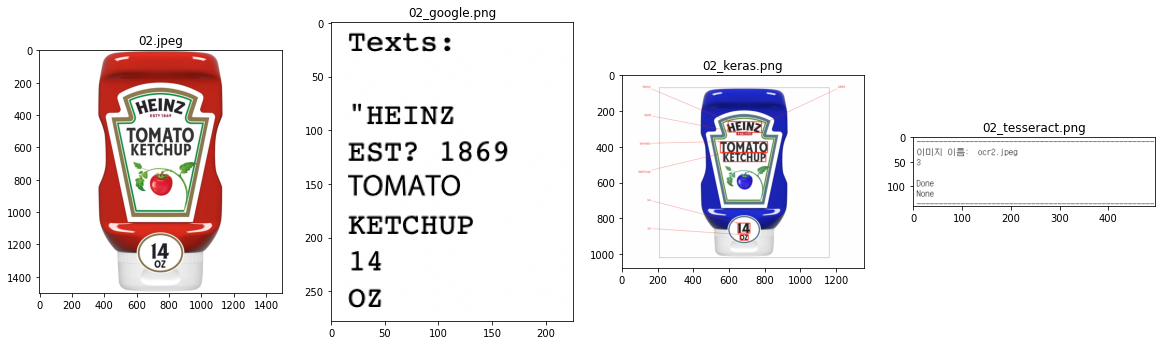

In [22]:
test_img2 = ['02.jpeg', '02_google.png', '02_keras.png', '02_tesseract.png']
plt.figure(figsize=(20,15))
for i in range(len(test_img2)):
    plt.subplot(1,4, i+1)
    plt.title(test_img2[i])
    plt.imshow(plt.imread(test_img2[i]))

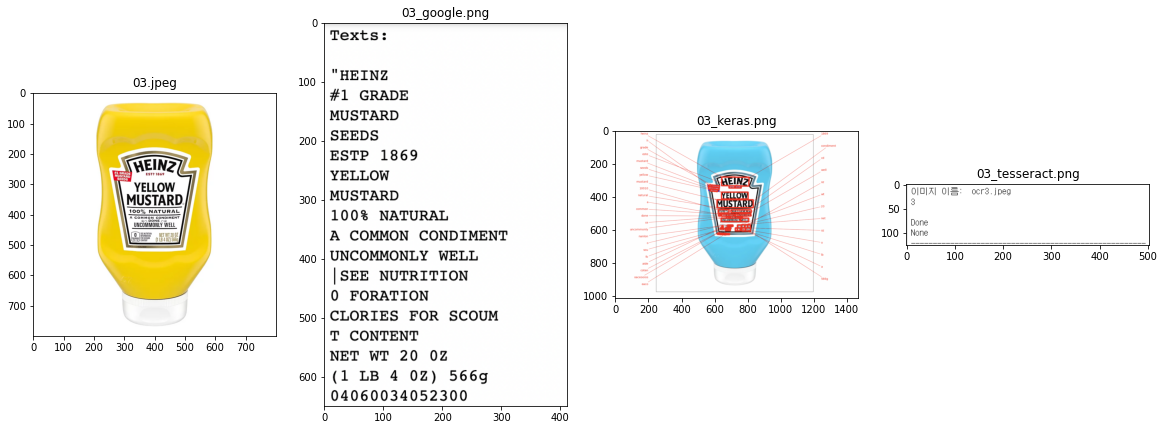

In [23]:
test_img3 = ['03.jpeg', '03_google.png', '03_keras.png', '03_tesseract.png']
plt.figure(figsize=(20,15))
for i in range(len(test_img3)):
    plt.subplot(1,4, i+1)
    plt.title(test_img3[i])
    plt.imshow(plt.imread(test_img3[i]))

# 회고

분석이 나온걸 보면 google이 확실히 다른 모델에 비해 정확하게 나온다,,

테서렉트는 사용하기 힘들정도의 정확도를 보여줬다.

항상 목요일이면 같이 모여서 익스를 진행했지만 

오늘처럼 코드를 나눠서 같이 한 건 처음이었다.

3명이서 한 모델씩 같이 힘을 합쳐 해내서 좋았다.